In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as opt
import matplotlib
from sklearn.metrics import classification_report#这个包是评价报告

# 读取数据并可视化
- 数据集:手写数字分类数据集
- X：shape（5000， 400），5000幅分辨率为20x20的图片
- y: shape （5000，1），每幅图片一个标签，标签为数字\[1,10]其中10代表数字“0”

In [2]:
# 读取数据
data = loadmat('ex3data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
raw_X = data['X']
raw_y = data['y']
raw_X.shape,raw_y.shape

((5000, 400), (5000, 1))

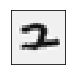

In [4]:
#绘制一张手写数字图
def plot_one_image(image):
    fig,ax = plt.subplots(figsize = (1,1))
    ax.matshow(image.reshape((20,20)), cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.show()
plot_one_image(raw_X[2020,:])

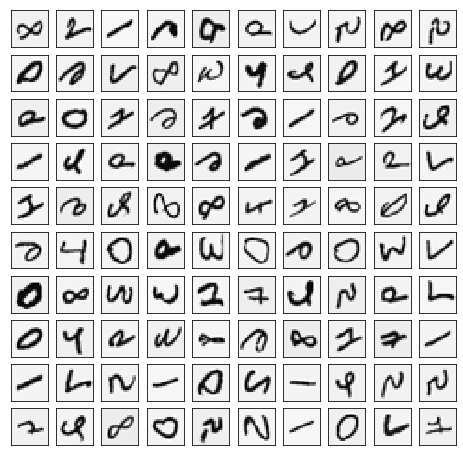

In [5]:
#绘制10X10，100张数字图 X : (5000, 400)
def plot_100_image(X):
    # 图片的长和宽
    size = int(np.sqrt(X.shape[1]))

    # 从全部数据集中随机采样100个图片
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 100*400
    sample_images = X[sample_idx, :]

    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))
    # 绘制
    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
plot_100_image(raw_X)            

# 数据初始化
- X：增加一列全为0的偏执向量，shape “5000， 401”
- y: 转换为one-hot向量。其中数字“0”为\[0,0,0,0,0,0,0,0,0,1]

In [6]:
# 增加一列偏执向量b
X = np.insert(raw_X, 0, np.ones(raw_X.shape[0]), axis = 1)
X.shape

(5000, 401)

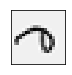

((5000, 10), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), None)

In [7]:
# 将y扩展为10维向量：独热向量
# 其中数字0的标签为[0,0,0,0,0,0,0,0,0,1]
def expend_y(raw_y):
    temp = []
    for i in range(5000):
        y_expend = np.zeros(10)
        for j in range(1,11):
            if raw_y[i] == j:
                y_expend[j-1] = 1
                temp.append(y_expend)
    return np.array(temp)        
y =  expend_y(raw_y)
y.shape,y[3456],plot_one_image(raw_X[3456,:])

# 前向传播（已知权重）
- ex4weights.mat文件中给出了训练好的参数，先用这个参数体验下前向传播的过程。之后在反向传播时将学会如何得到这组参数
- 这是一个有1层隐藏层的全连接神经网络，隐藏层相当于Linear(401, 25)
- 输出层相当于Linear(25, 10)，其中使用sigmoid函数激活

In [8]:
# sigmoid函数
def sigmoid(z):
    return 1 / (1 + np.e**-z)

In [9]:
# 读取权重
w = loadmat('ex4weights.mat')
theta1 = w['Theta1']
theta2 = w['Theta2']
theta1.shape,theta2.shape

((25, 401), (10, 26))

In [10]:
"""参数展开"""
# 将隐藏层和输出层的参数展开放在一个一维向量中
def unrolling_paramteters(a, b):
    return np.hstack([a.ravel(), b.ravel()])
theta = unrolling_paramteters(theta1, theta2)  
theta.shape

(10285,)

In [11]:
"""参数还原"""
# 将一维度向量展开为两个二维参数矩阵
def rolling_parameters(theta):
    theta1 = theta[:25*401].reshape((25, 401))
    theta2 = theta[25*401:].reshape((10, 26))
    return theta1,theta2
t1,t2 = rolling_parameters(theta)
t1.shape,t2.shape

((25, 401), (10, 26))

In [12]:
# 前向传播
def feedforward(theta, X):
    # 传入的theta为展开了的参数，因此首先要恢复他们
    theta1,theta2 = rolling_parameters(theta)
    # 隐藏层
    a_1 = X
    z_2 = theta1 @ a_1.T
    a_2 = sigmoid(z_2)
    # 输出层
    a_2 = np.insert(a_2, 0, np.ones(X.shape[0]), axis = 0) # 加上偏执向量
    z_3 = theta2 @ a_2
    a_3 = sigmoid(z_3)
    h = a_3.T
    cache = [a_1, z_2, a_2, z_3, h]
    return cache
a_1,z_2,a_2,z_3,h = feedforward(theta, X)
a_1.shape,z_2.shape,a_2.shape,z_3.shape,h.shape

((5000, 401), (25, 5000), (26, 5000), (10, 5000), (5000, 10))

In [13]:
"""评估模型的准确性"""
def show_accuracy(theta,y):
    data = loadmat('ex3data1.mat')
    y_acc = data['y']
    _,_,_,_,h = feedforward(theta,X)
    y_pred = np.argmax(h , axis =1) + 1
    return print(classification_report(y_acc, y_pred))
show_accuracy(theta,y)

              precision    recall  f1-score   support

           1       0.97      0.98      0.98       500
           2       0.98      0.97      0.98       500
           3       0.98      0.96      0.97       500
           4       0.97      0.97      0.97       500
           5       0.97      0.98      0.98       500
           6       0.98      0.99      0.98       500
           7       0.98      0.97      0.97       500
           8       0.98      0.98      0.98       500
           9       0.97      0.96      0.96       500
          10       0.98      0.99      0.99       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



# 代价函数

In [14]:
# 代价\损失函数
def costfunction(theta,X, y,):
    # 前向传播得到输出
    _,_,_,_,h = feedforward(theta,X,)
    # 交叉熵损失
    pos = -np.log(h) * y
    neg = -np.log(1 - h) * (1 - y)
    return 1/len(X)*np.sum(pos + neg)
costfunction(theta,X, y,)

0.287629165161319

In [15]:
# 正则化代价
def costfunction_reg(theta,X, y, l = 1):
    # 传入的theta为展开了的参数，因此首先要恢复他们
    theta1, theta2 = rolling_parameters(theta)
    # L2正则化：权重参数的平方和
    reg = l/(2 * len(X)) * (np.sum(theta1[:,1:]**2) + np.sum(theta2[:,1:]**2))
    return costfunction(theta, X, y) + reg
costfunction_reg(theta, X, y, l = 1)

0.3837698590909237

# 反向传播-准备工作

In [16]:
# sigmoid函数的导数
def sigmoid_gradient(z):
    return sigmoid(z) * (1 - sigmoid(z))
sigmoid_gradient(0)

0.25

In [17]:
# 随机初始化权重
# 在[-epsilon,epsilon]范围内随机取n个数
def randinit_wights(n, epsilon = 0.12):
    return np.random.uniform(-epsilon, epsilon, n)

In [18]:
# 梯度检测
def gradient_check(thetaVec,gradAnalytic):
    Epsilon = 0.00001
    thetaMinus = thetaVec
    thetaPlus = thetaVec
    for i in range(len(thetaVec)):
        thetaPlus[i] = thetaPlus[i] + Epsilon
        thetaMinus[i] = thetaMinus[i] - Epsilon
        gradApprox = (costfunction(thetaPlus,X,y) -costfunction(thetaMinus,X,y))/(2 * Epsilon)
        diff = np.mean(gradApprox - gradient)
    return diff

# 反向传播算法

In [19]:
# 计算每个权重的梯度
def bp_gradient(theta,X, y, cache):
    theta1,theta2 = rolling_parameters(theta)
    # 保存隐藏层的梯度
    Delta_1 = np.zeros(theta1.shape)
    # 保存输出层的梯度
    Delta_2 = np.zeros(theta2.shape)
    # 前向传播
    a_1, z_2, a_2, z_3, h = cache
    # 使用全部数据集做一次梯度下降，即BGD，批量梯度下降
    for i in range(X.shape[0]):
        a_1i = a_1[i,:] #（401，）
        z_2i = z_2[:,i] #（25，）
        a_2i = a_2[:,i] #（26，）
        z_3i = z_3[:,i] #（10，）
        h_i = h[i,:]    #（10，）
        y_i = y[i,:]    #（10，）
        delta_3i = h_i - y_i  #（10，）
        z_2i = np.hstack([1,z_2[:,i]]) #（26，）
        delta_2i = theta2.T @ delta_3i * sigmoid_gradient(z_2i)
        Delta_2 = Delta_2 + delta_3i[:,np.newaxis] @ a_2i[:,np.newaxis].T
        Delta_1 = Delta_1 + delta_2i[1:,np.newaxis] @ a_1i[:,np.newaxis].T
    return unrolling_paramteters(Delta_1/len(X), Delta_2/len(X))
# 测试
theta = randinit_wights(n = 10285)
cache = feedforward(theta, X)
gradient = bp_gradient(theta, X, y, cache)
D_1,D_2 = rolling_parameters(gradient)
D_1.shape,D_2.shape,gradient.shape

((25, 401), (10, 26), (10285,))

In [20]:
# 梯度检测，超级慢要运行10分钟左右！！
# 两者的平均每个梯度的差距是0.0055左右,说明梯度计算应该没问题的
gradient_check(theta,gradient)

-0.005564661153500351

In [21]:
# 正则化梯度
def bp_gradient_reg(theta, X, y, cache, l=1):
    # 正常的反向传播
    Delta1, Delta2 = rolling_parameters(bp_gradient(theta,X, y, cache))
    theta1, theta2 = rolling_parameters(theta)
    
    # L1正则化
    theta1[:, 0] = 0 # 将偏执b设为0，因为b不需要参与正则化
    Delta1_reg = (l / len(X)) * theta1
    Delta1 = Delta1 + Delta1_reg
    theta2[:, 0] = 0
    Delta2_reg = (l / len(X)) * theta2
    delta2 = Delta2 + Delta2_reg
    return unrolling_paramteters(Delta1, Delta2)
D1,D2 = rolling_parameters(bp_gradient_reg(theta, X, y, l=1, cache=cache))
D1.shape,D2.shape

((25, 401), (10, 26))

# 训练神经网络模型
- 刚开始时我忘了用带正则化的反向传播算法，导致无论是使用BGD，BGD + Momentum还是RMSprop优化器。loss都只收敛到了3.2左右
- 后来加上了正则化后，统一设置epochs=500，lr=0.01，momentum=0.99。BGD在loss=3.0附近还是慢了下来，BGD + Momentum成功越过了loss=3但是还是效率不高（应该增加迭代次数最后还是能收敛），RMSprop成功快速收敛到了loss=1.6左右
- 最后使用RMSprop优化器，设置learning_rate=0.05, mu=0.99, epochs=2000，最终loss收敛到0.36


 epoch:1999	loss:0.3704 

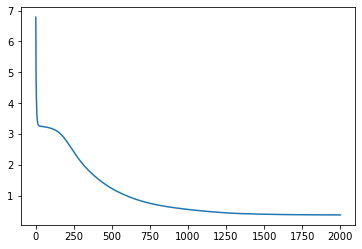

In [22]:
# 学习率太大收敛太快，容易快速陷入局部解；太小，收纳太慢了！
def train(X, y, learning_rate=0.05, mu=0.99, epochs=2000):
    # 随机初始化权重
    v = 0 # BGD + Momentum和RMSprop优化器需要用到的速度
    theta = randinit_wights(10285)
    costs = [] 
    for epoch in range(epochs):
        # 记录损失
        cost = costfunction_reg(theta, X, y)
        costs.append(cost)
        print('\r', f"epoch:{epoch}\tloss:{cost:.4f}", end=" ")
        # 前向传播
        cache = feedforward(theta, X)
       
        # 反向传播得到参数的梯度，之后这里使用RMSprop优化器更新参数
        gradient = bp_gradient_reg(theta, X, y, cache)
        v = mu*v + (1-mu) * gradient @ gradient
        D_1,D_2 = rolling_parameters(gradient)
        theta1, theta2 = rolling_parameters(theta)
        theta1 -= learning_rate/(np.sqrt(v) + 0.0001) * D_1
        theta2 -= learning_rate/(np.sqrt(v) + 0.0001) * D_2
        # BGD
        # D_1,D_2 = rolling_parameters(gradient)
        # 用梯度更新权重,RMSprop
        # BGD + Momentum

        # v = mu * v - learning_rate * gradient
        # D_1,D_2 = rolling_parameters(-v)
        
        # BGD
        # theta1 -= learning_rate * D_1
        # theta2 -= learning_rate * D_2
        
        theta = unrolling_paramteters(theta1, theta2)
    # 绘制loss曲线
    plt.plot(costs)
    plt.show()
    return theta
theta = train(X, y)

In [23]:
# 评估
show_accuracy(theta,y)

              precision    recall  f1-score   support

           1       0.98      0.99      0.99       500
           2       0.98      0.98      0.98       500
           3       0.99      0.97      0.98       500
           4       0.98      0.98      0.98       500
           5       0.98      0.99      0.99       500
           6       1.00      0.99      0.99       500
           7       0.99      0.99      0.99       500
           8       0.99      0.99      0.99       500
           9       0.98      0.98      0.98       500
          10       0.99      1.00      0.99       500

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



oh!99%正确率的模型！！

# 隐藏层和输出层的参数可视化

(25, 400)
(10, 25)


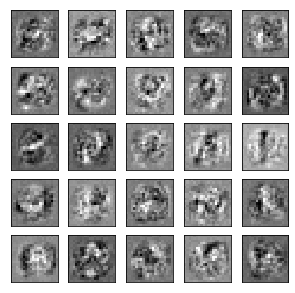

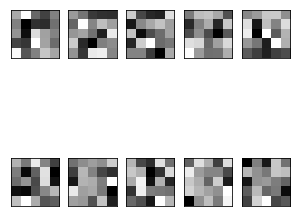

In [24]:
def vis_layer(layer, size):
    n = 5 if layer.shape[0]//5 > 5 else layer.shape[0]//5
    fig, ax_array = plt.subplots(nrows=n, ncols=5, sharey=True, sharex=True, figsize=(5, 5))
    for r in range(n):
        for c in range(5):
            ax_array[r, c].matshow(layer[5 * r + c].reshape(size,size),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

def plot_hidden_layer(theta):
    final_theta1, final_theta2 = rolling_parameters(theta)
    hidden_layer = final_theta1[:, 1:]  # 去除偏执项
    input_layer = final_theta2[:, 1:]
    print(hidden_layer.shape)
    print(input_layer.shape)
    # 隐藏层
    vis_layer(hidden_layer, 20)
    # 输出层
    vis_layer(input_layer, 5)
plot_hidden_layer(theta)
plt.show()